## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

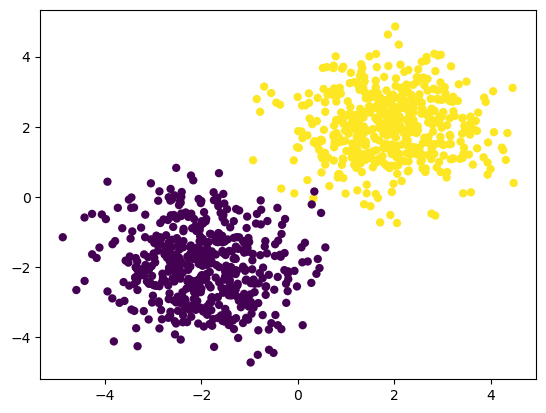

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()
print(net)

# Test something like that then 

'''net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())'''

Linear 2 -> 2
LogSoftMax



'net = Sequential()\nnet.add(Linear(2, 4))\nnet.add(ReLU())\nnet.add(Linear(4, 2))\nnet.add(LogSoftMax())'

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

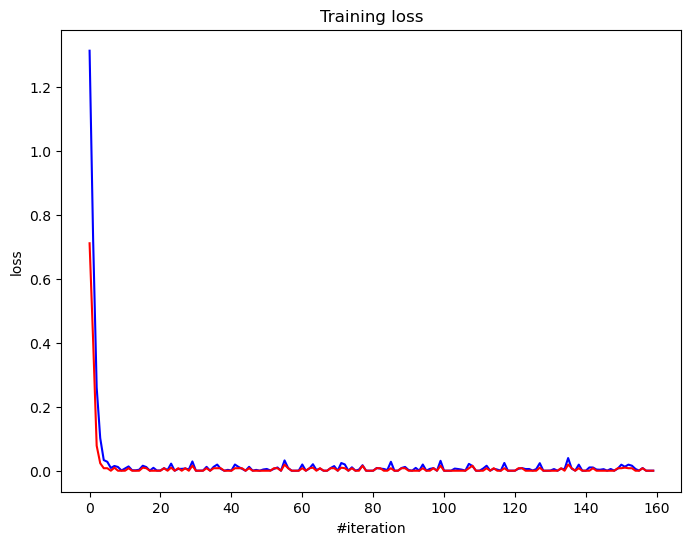

Current loss: 0.000189
Current acc: 1.000000


In [7]:
loss_history = []
acc_history = []
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        acc_history.append(np.mean(predictions.argmax(axis=1)==y_batch.argmax(axis=1)))
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.plot(1-np.array(acc_history), 'r')
    plt.show()
    
    print('Current loss: %f' % loss)     
    print('Current acc: %f' % acc_history[-1])    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [8]:

import os, struct, gzip, numpy as np

def _smart_open(path):
    # transparently handle .gz files
    return gzip.open(path, 'rb') if path.endswith('.gz') else open(path, 'rb')

def find_file(base_path, fname):
    """Return the real file, no matter how Kaggle wrapped it."""
    direct = os.path.join(base_path, fname)                 # /…/fname
    wrapped = os.path.join(base_path, fname, fname)         # /…/fname/fname
    for p in (direct, direct + '.gz', wrapped, wrapped + '.gz'):
        if os.path.isfile(p):
            return p
    raise FileNotFoundError(f'{fname} not found under {base_path}')

def load_images(path):
    with _smart_open(path) as f:
        magic, size = struct.unpack(">II", f.read(8))
        rows, cols  = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(rows * cols * size), dtype=np.uint8)
        return data.reshape(size, rows * cols)

def load_labels(path):
    with _smart_open(path) as f:
        _, size = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(size), dtype=np.uint8)

def load_mnist_data():
    X_train = load_images('train-images.idx3-ubyte')
    y_train = load_labels('train-labels.idx1-ubyte')
    X_test  = load_images('t10k-images.idx3-ubyte')
    y_test  = load_labels('t10k-labels.idx1-ubyte')
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_mnist_data()
print(X_train.shape, y_train.shape)   # (60000, 784) (60000,)

(60000, 784) (60000,)


In [9]:
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

# One-hot encode all sets
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
def train_network(net, criterion, optimizer_config, optimizer_state, dataset, 
                 n_epoch=10, batch_size=128, optimizer_fn=sgd_momentum):
    X, y = dataset
    loss_history = []
    
    for epoch in range(n_epoch):
        for x_batch, y_batch in get_batches((X, y), batch_size):
            net.zeroGradParameters()
            
            # Forward pass
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            
            # Backward pass
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optimizer_fn(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)
            
            loss_history.append(loss)
            
    return loss_history

In [12]:
# Your code goes here. ################################################
def build_network(activation_fn):
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(activation_fn())
    net.add(Linear(256, 10))
    net.add(LogSoftMax())
    return net

activations = {
    'ReLU': ReLU,
    'ELU': lambda: ELU(alpha=1.0),
    'LeakyReLU': lambda: LeakyReLU(slope=0.01),
    'SoftPlus': SoftPlus
}

results = {}

for name, activation in activations.items():
    print(f"Training with {name} activation...")
    net = build_network(activation)
    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate': 1e-3, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history = train_network(net, criterion, optimizer_config, optimizer_state, 
                               (X_train, y_train), n_epoch=10, batch_size=128)
    results[name] = loss_history

Training with ReLU activation...
Training with ELU activation...
Training with LeakyReLU activation...
Training with SoftPlus activation...


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [13]:
# Your answer goes here. ################################################
def build_bn_network(activation_fn):
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(256))
    net.add(activation_fn())
    net.add(Linear(256, 10))
    net.add(LogSoftMax())
    return net

bn_results = {}

for name, activation in activations.items():
    print(f"Training with BN and {name} activation...")
    net = build_bn_network(activation)
    criterion = ClassNLLCriterion()
    optimizer_config = {'learning_rate': 1e-3, 'momentum': 0.9}
    optimizer_state = {}
    
    loss_history = train_network(net, criterion, optimizer_config, optimizer_state,
                               (X_train, y_train), n_epoch=10, batch_size=128)
    bn_results[name] = loss_history

Training with BN and ReLU activation...
Training with BN and ELU activation...
Training with BN and LeakyReLU activation...
Training with BN and SoftPlus activation...


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

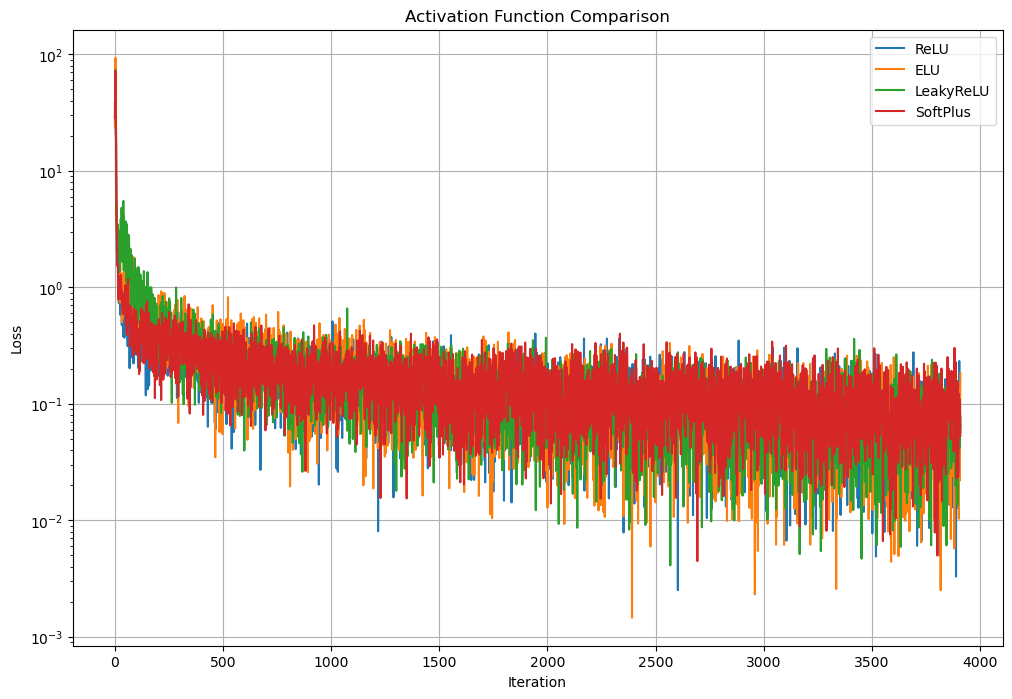

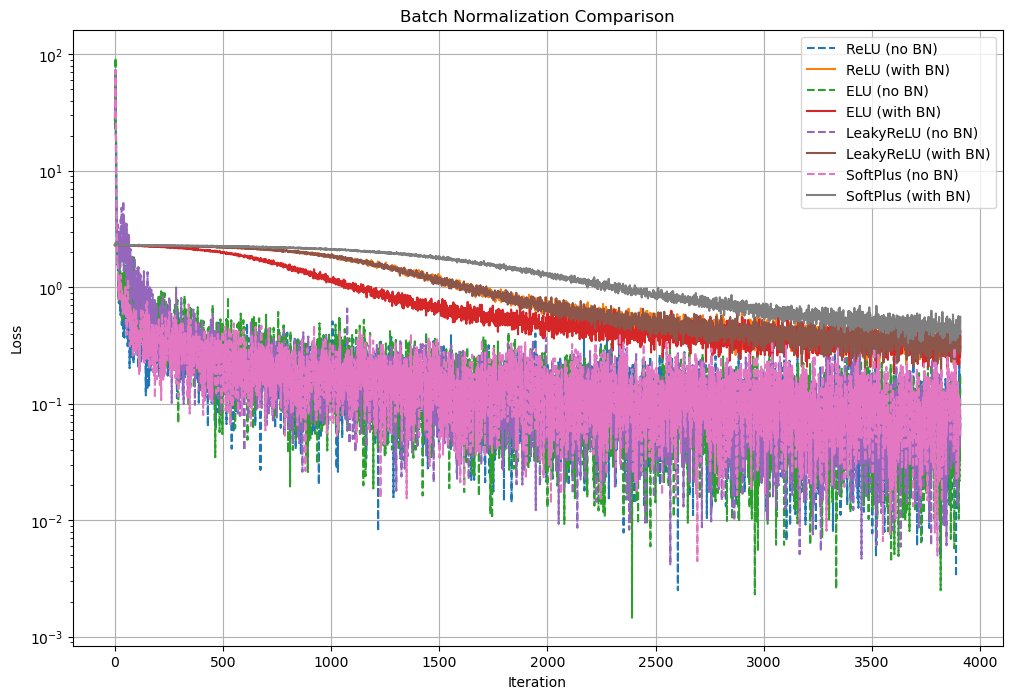

In [14]:
# Your code goes here. ################################################
plt.figure(figsize=(12, 8))

# Plot activation comparisons
for name, losses in results.items():
    plt.plot(losses, label=f"{name}")
    
plt.title("Activation Function Comparison")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))

# Plot BN vs no BN
for name in activations.keys():
    plt.plot(results[name], '--', label=f"{name} (no BN)")
    plt.plot(bn_results[name], '-', label=f"{name} (with BN)")
    
plt.title("Batch Normalization Comparison")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

Print here your accuracy on test set. It should be around 90%.

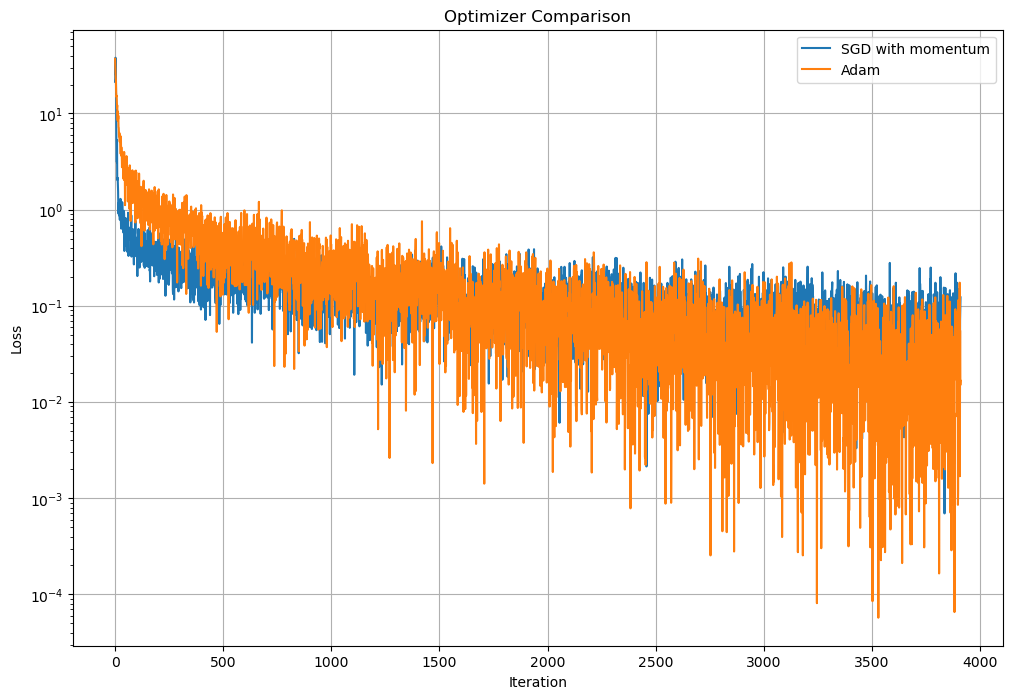

In [15]:
# Your answer goes here. ################################################
net_sgd = build_network(ReLU)
net_adam = build_network(ReLU)

# SGD with momentum
sgd_loss = train_network(net_sgd, ClassNLLCriterion(),
                        {'learning_rate': 1e-3, 'momentum': 0.9}, {},
                        (X_train, y_train), n_epoch=10, batch_size=128)

# Adam
adam_loss = train_network(net_adam, ClassNLLCriterion(),
                         {'learning_rate': 1e-4, 'beta1': 0.4, 'beta2': 0.9, 'epsilon': 1e-8},
                         {}, (X_train, y_train), n_epoch=10, batch_size=128,
                         optimizer_fn=adam_optimizer)

plt.figure(figsize=(12, 8))
plt.plot(sgd_loss, label="SGD with momentum")
plt.plot(adam_loss, label="Adam")
plt.title("Optimizer Comparison")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [16]:
def build_final_model():
    net = Sequential()
    net.add(Linear(784, 512))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(512))
    net.add(ReLU())
    net.add(Dropout(p=0.5))
    
    net.add(Linear(512, 256))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(256))
    net.add(ReLU())
    net.add(Dropout(p=0.3))
    
    net.add(Linear(256, 10))
    net.add(LogSoftMax())
    return net

# Simple data augmentation - random shifts
def augment_data(X, max_shift=2):
    shifted = np.zeros_like(X)
    for i in range(X.shape[0]):
        img = X[i].reshape(28, 28)
        dx, dy = np.random.randint(-max_shift, max_shift+1, size=2)
        shifted_img = np.roll(img, (dy, dx), axis=(0, 1))
        shifted[i] = shifted_img.reshape(-1)
    return shifted

# Training with augmentation
final_net = build_final_model()
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}

for epoch in range(20):
    # Set to training mode (important for dropout and BN)
    final_net.train()
    
    for x_batch, y_batch in get_batches((X_train, y_train), 128):
        # Augment the batch
        x_batch = augment_data(x_batch)
        
        final_net.zeroGradParameters()
        predictions = final_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        final_net.backward(x_batch, dp)
        
        adam_optimizer(final_net.getParameters(),
                      final_net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

# Evaluation
final_net.evaluate()
test_predictions = final_net.forward(X_test)
test_loss = criterion.forward(test_predictions, y_test)
accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1))
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 98.41%


### Comparing with PyTorch implementation
The last (and maybe the easiest) step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

__Good Luck!__

In [ ]:
# Your beautiful code here.